In [2]:
import json
import os
import seaborn as sns

RESULTS_DIR = '../experiments/results/'

def read_json(path):
    with open(path, 'r') as f: 
        res = json.load(f)
    return res
tasks = read_json('../experiments/tasks.json')
# results = [read_json(os.path.join(RESULTS_DIR, path)) for path in os.listdir(RESULTS_DIR)]

In [3]:
def query_job_ids(algorithm=None, data_type=None, n_qubits=None):
    filtered_tasks = tasks
    if algorithm is not None:
        filtered_tasks = [task for task in filtered_tasks if task['algorithm']==algorithm]
    if data_type is not None:
        filtered_tasks = [task for task in filtered_tasks if task['data_type']==data_type]
    if n_qubits is not None:
        filtered_tasks = [task for task in filtered_tasks if task['n_qubits']==n_qubits]
    return [t['id'] for t in filtered_tasks if os.path.isfile(os.path.join(RESULTS_DIR, f'{t["id"]}.json'))]

# Графики

* качество lptn от ранга
* качество разных алгоритмов от числа кубит
* время обучения для разных алгоритмов и кубит
* число шагов для разных алгоритмов и кубит
* потребляемая память для разных алгоритмов и кубит
* гистограмма fidelity для lptn

In [4]:
qubits_range = list(range(1,8))

### Качество lptn от ранга

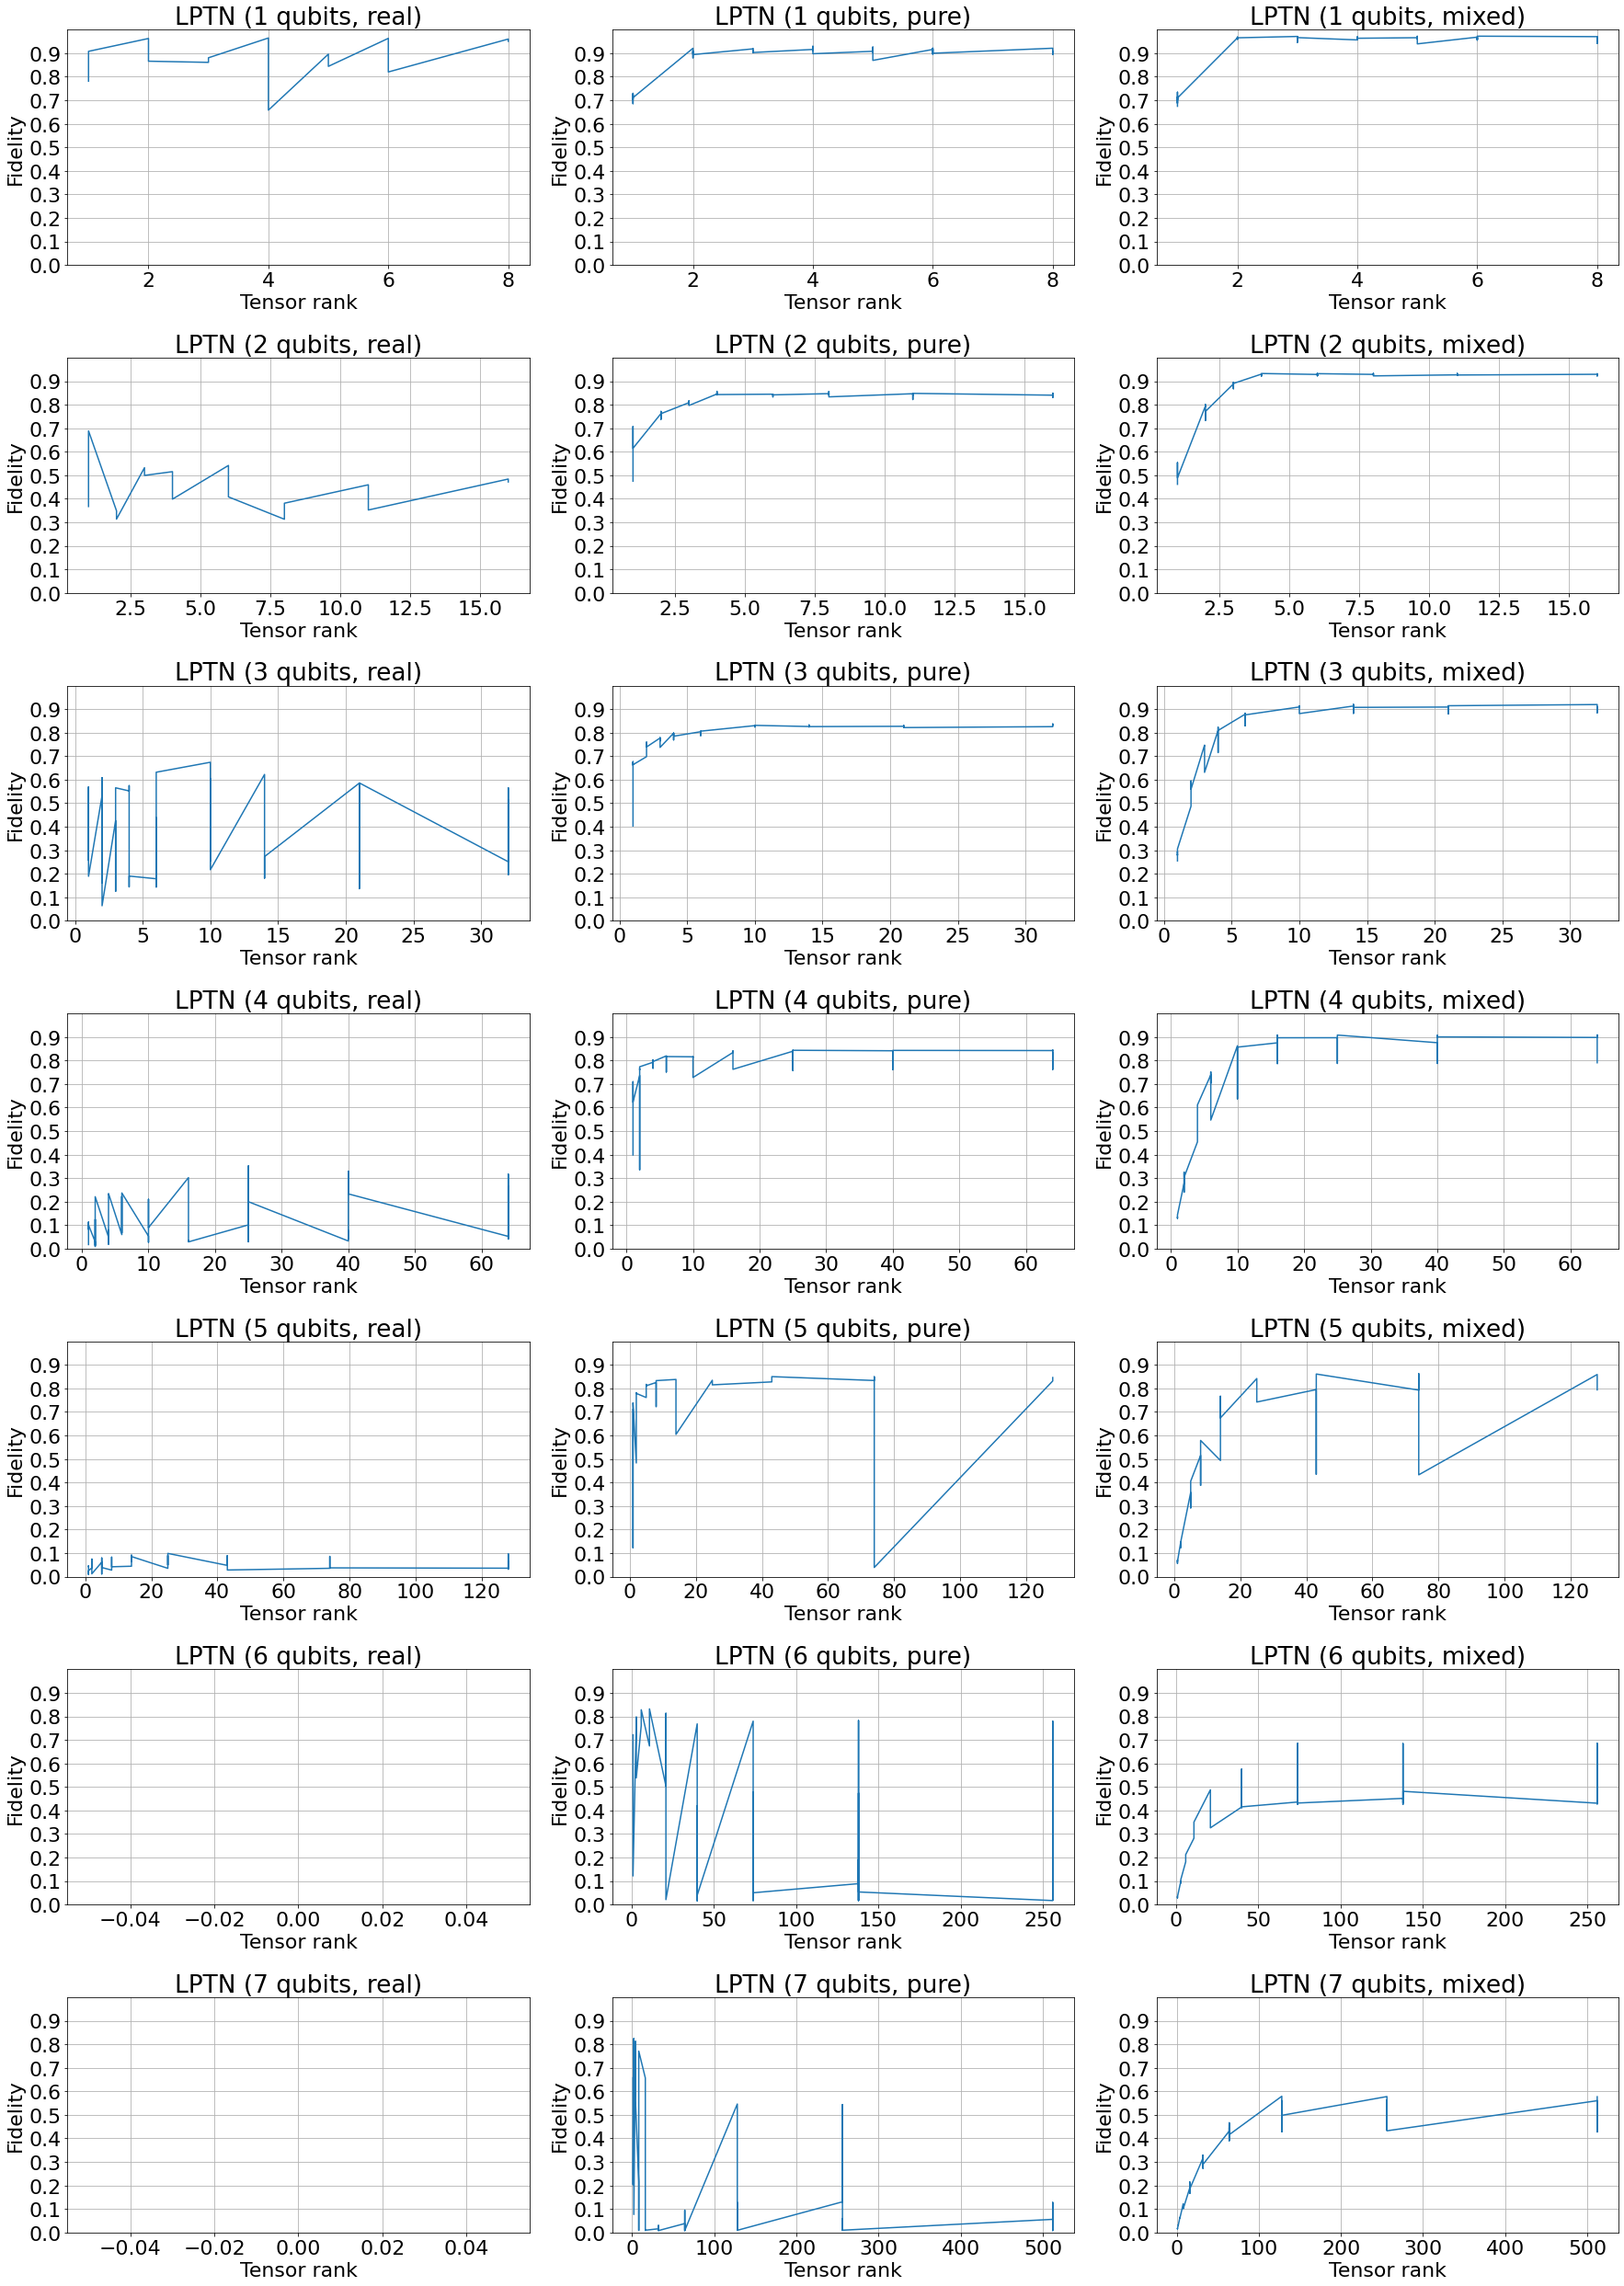

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,5*len(qubits_range)))
plt.rcParams.update({'font.size': 22})


for n_qubits in qubits_range:
    for i, data_type in enumerate(['real', 'pure', 'mixed']):
        plt.subplot(len(qubits_range), 3, 3*(n_qubits - 1) + i+1)
        task_ids = query_job_ids('lptn', data_type, n_qubits)
        tensor_ranks = np.array([tasks[i]['tensor_rank'] for i in task_ids])
        sorted_idx = np.argsort(tensor_ranks)
        fidelities = np.array([np.mean([max(x['fidelities']) for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']]) for tid in task_ids])
        plt.ylabel('Fidelity')
        plt.xlabel('Tensor rank')
        plt.title(f'LPTN ({n_qubits} qubits, {data_type})')
        plt.yticks([0.1*i for i in range(10)])
        plt.ylim((0,1))
        plt.grid()
        plt.plot(tensor_ranks[sorted_idx], fidelities[sorted_idx])
plt.tight_layout()

## Гистограмма fidelity для lptn

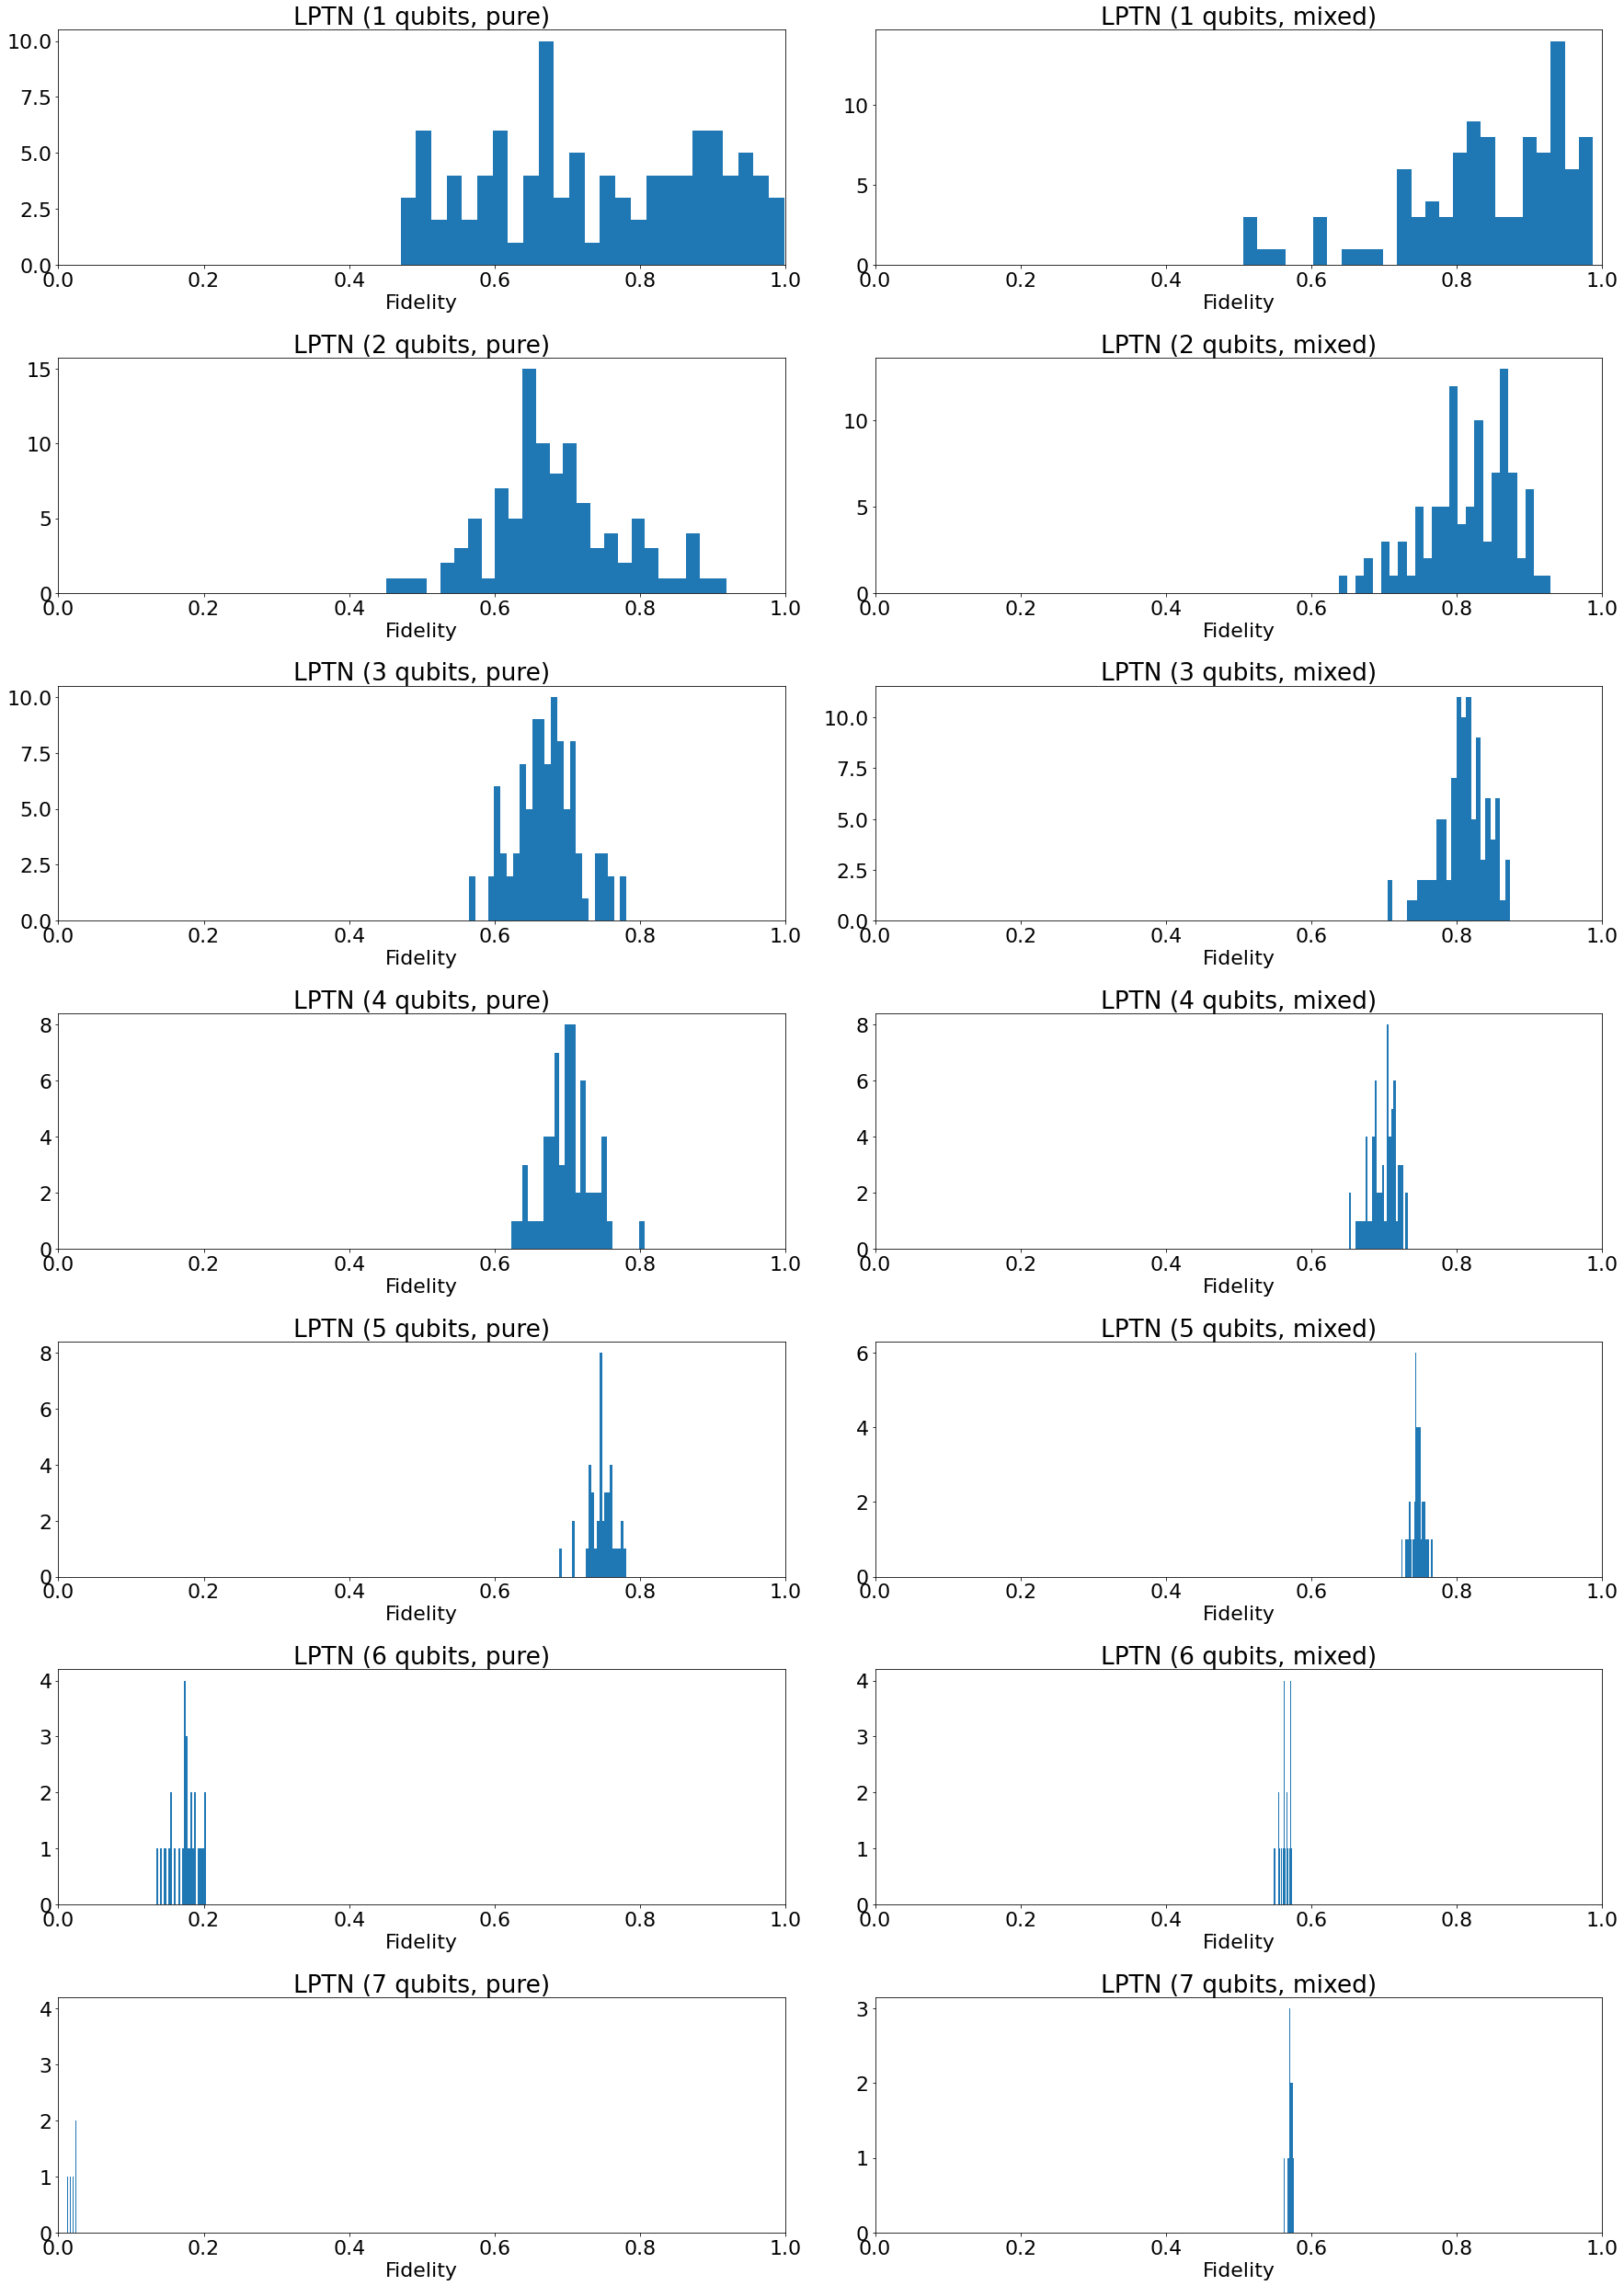

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,5*len(qubits_range)))
plt.rcParams.update({'font.size': 22})


for n_qubits in qubits_range:
    for i, data_type in enumerate(['pure', 'mixed']):
        plt.subplot(len(qubits_range), 2, 2*(n_qubits - 1) + i+1)
        task_ids = query_job_ids('lptn', data_type, n_qubits)
        if len(task_ids) == 0: continue
        tensor_ranks = np.array([tasks[i]['tensor_rank'] for i in task_ids])
        sorted_idx = np.argsort(tensor_ranks)
        fidelities = np.array([[np.mean(x['fidelities']) for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
        fidelities = fidelities[sorted_idx[-1]]
        plt.xlabel('Fidelity')
        plt.title(f'LPTN ({n_qubits} qubits, {data_type})')
        plt.hist(fidelities, bins=25)
        plt.xlim((0,1))
plt.tight_layout()

## Качество разных алгоритмов от числа кубит

In [112]:
qubits_range = list(range(1,8))

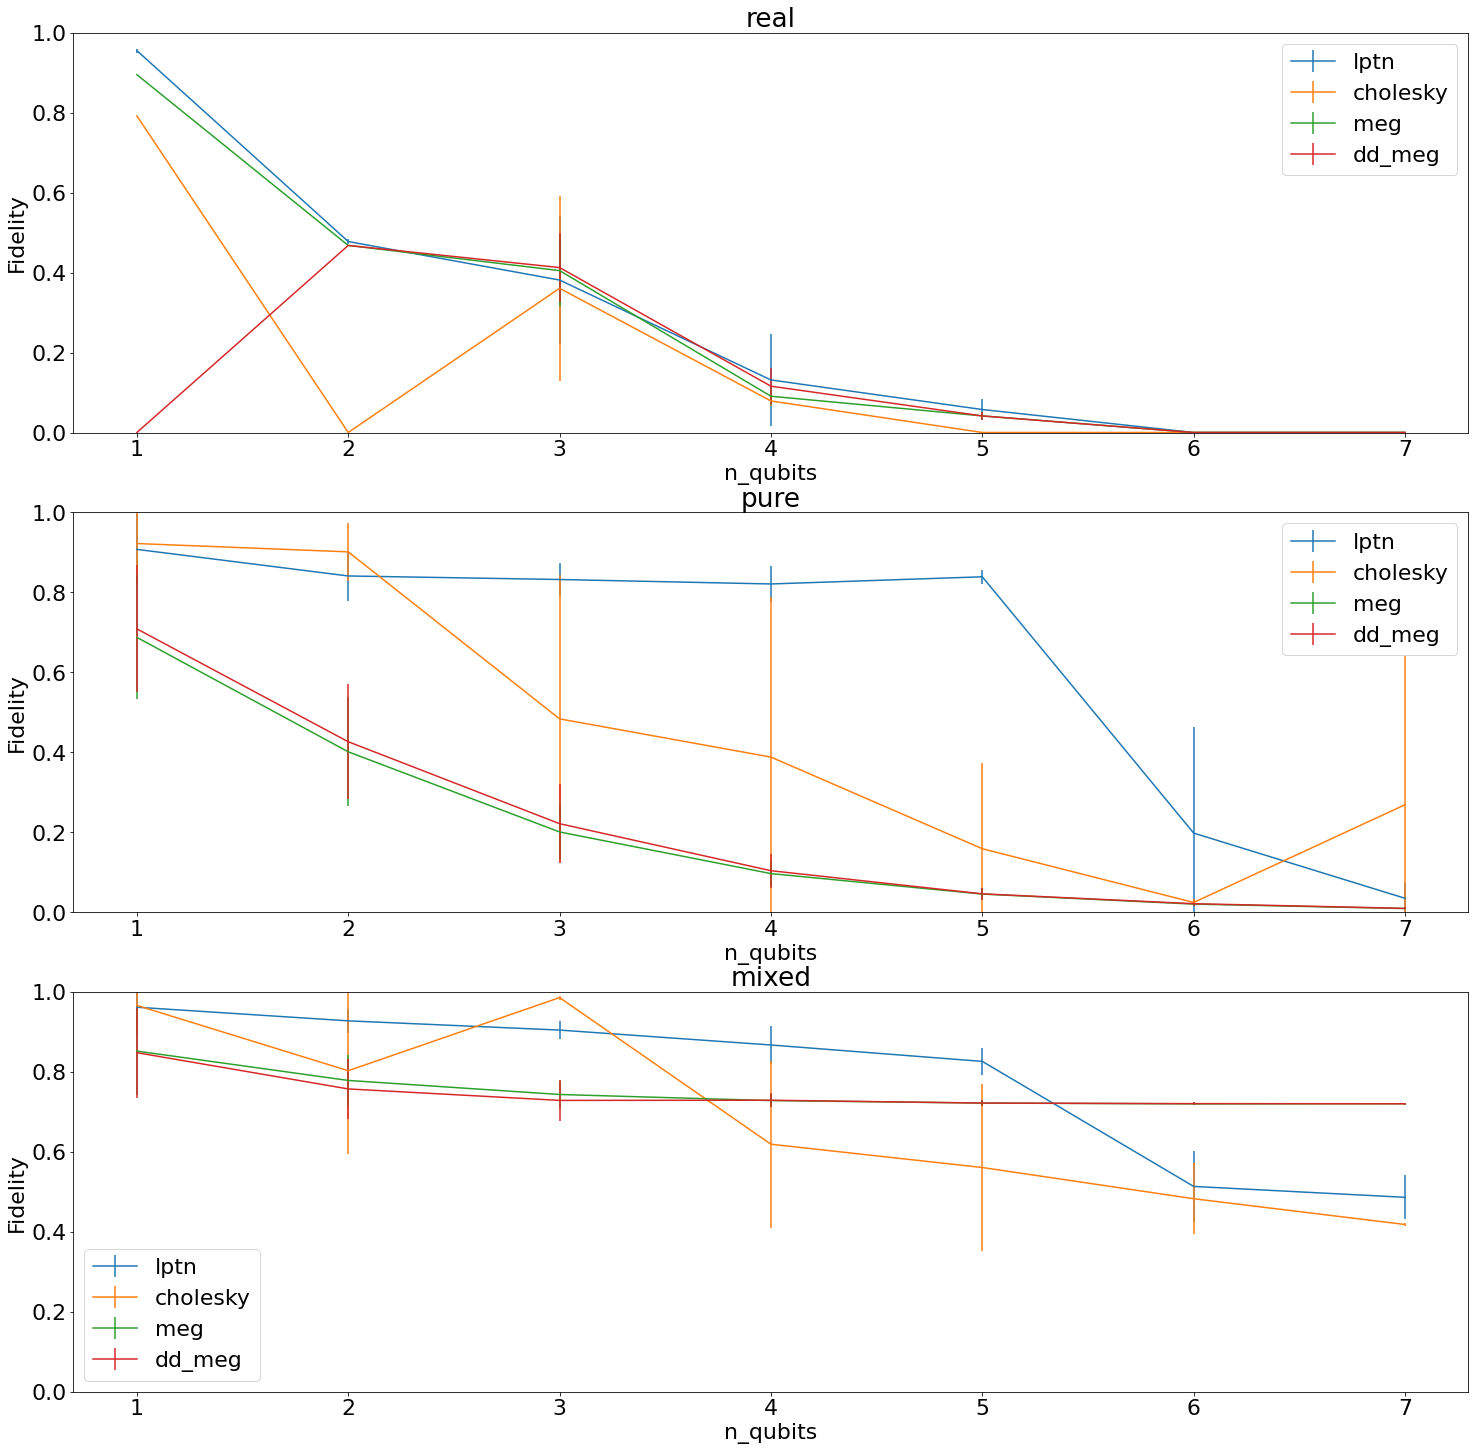

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            fidelities = np.array([[max(x['fidelities']) for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[i]['tensor_rank'] for i in task_ids])
                fidelities = fidelities[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(fidelities), np.std(fidelities)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("Fidelity")
        plt.ylim((0,1))
#         plt.yscale('log')
    plt.legend()

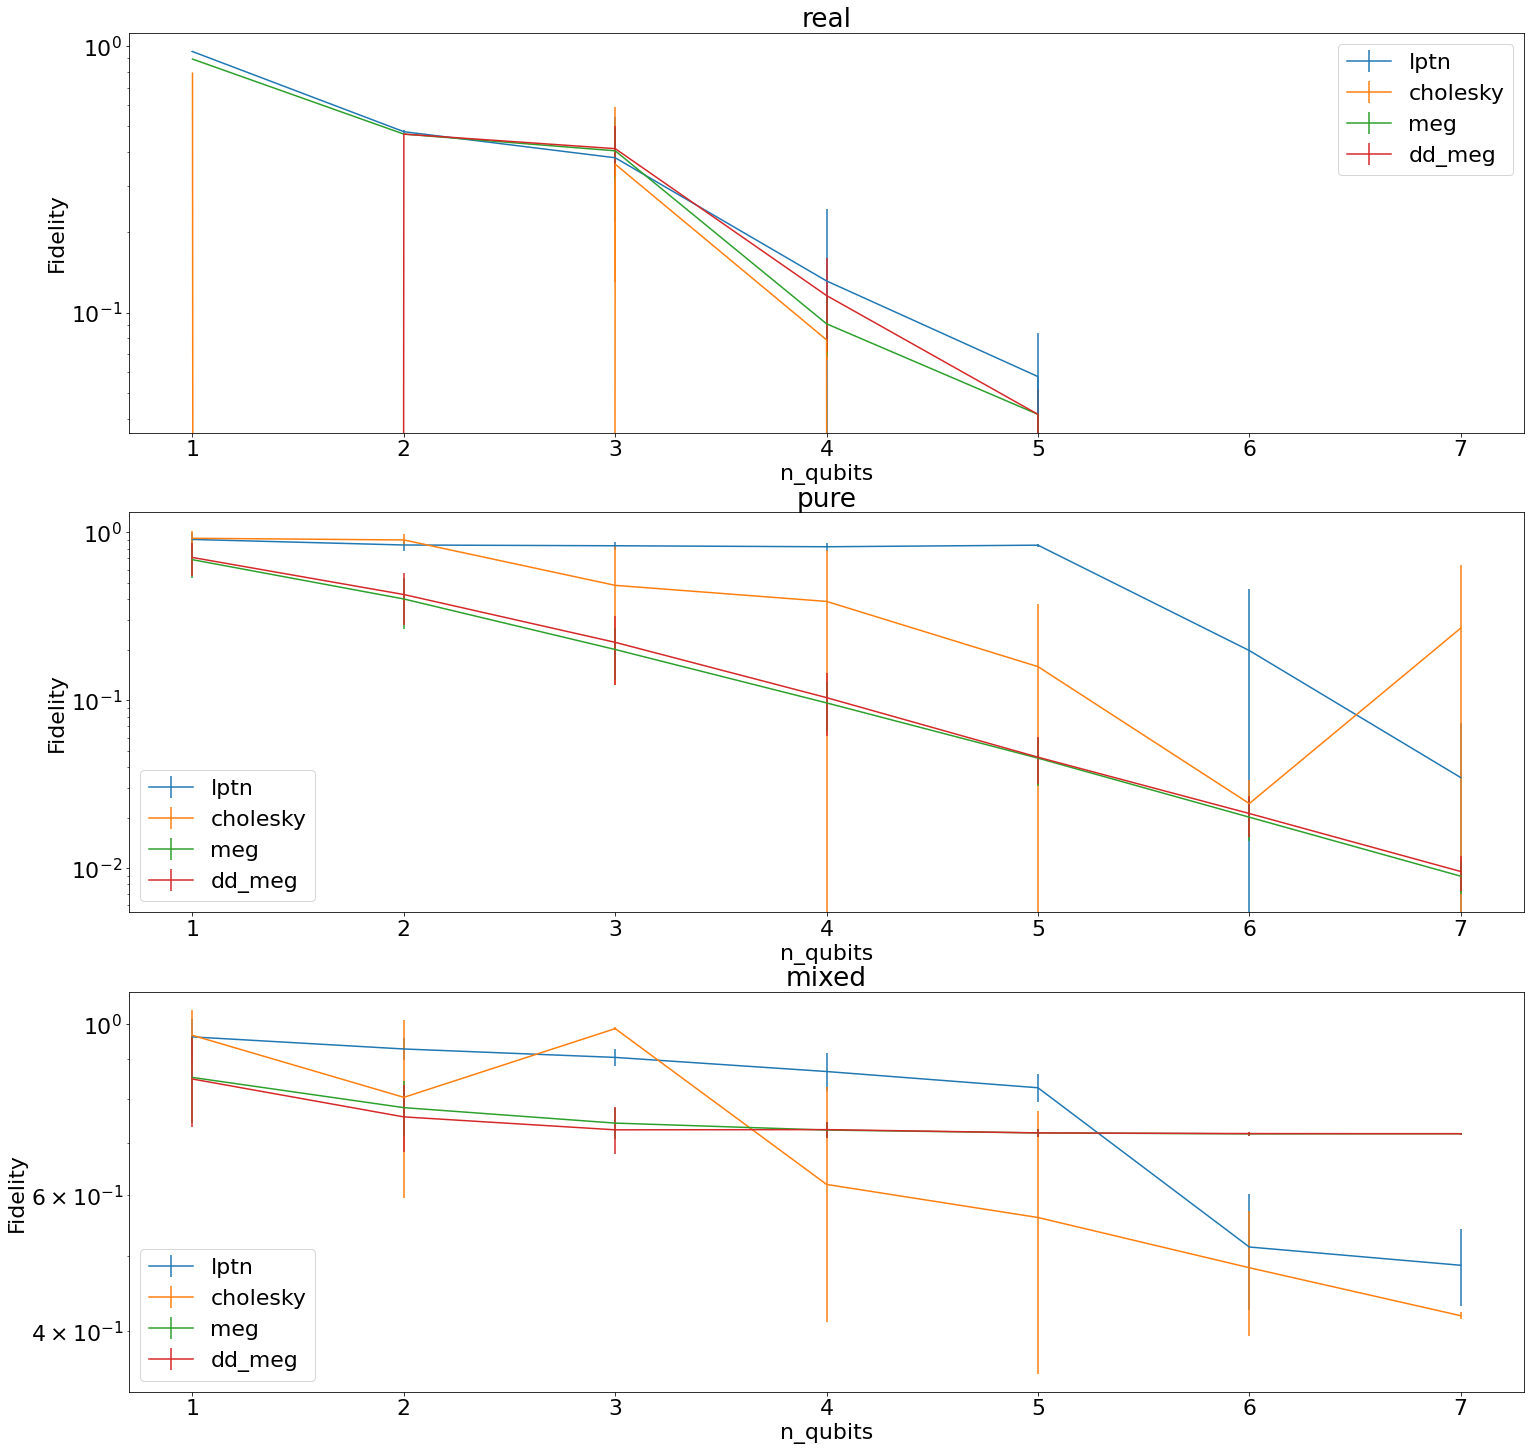

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            fidelities = np.array([[max(x['fidelities']) for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[tid]['tensor_rank'] for tid in task_ids])
                fidelities = fidelities[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(fidelities), np.std(fidelities)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("Fidelity")
#         plt.ylim((0,1))
        plt.yscale('log')
    plt.legend()

## Время обучения для разных алгоритмов и кубит

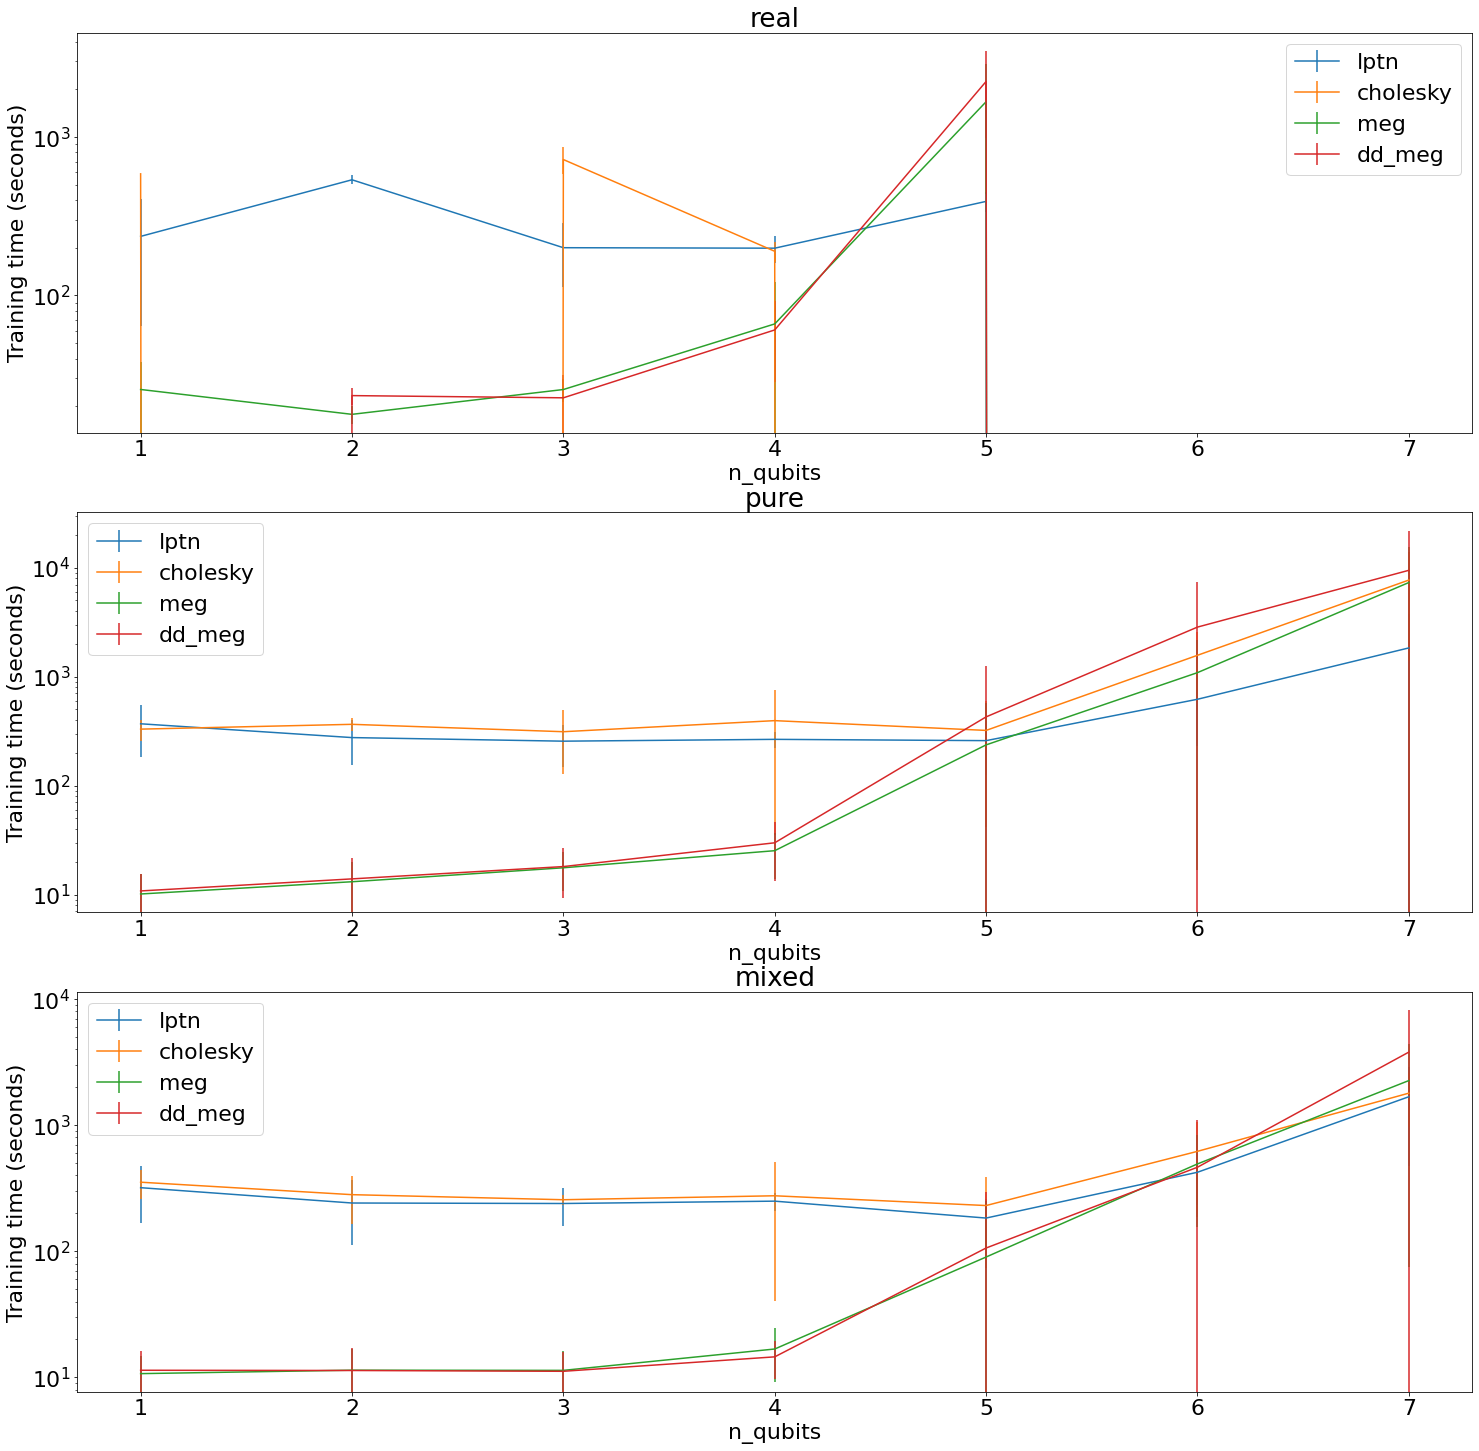

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            training_time = np.array([[x['time'] for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[tid]['tensor_rank'] for tid in task_ids])
                training_time = training_time[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(training_time), np.std(training_time)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("Training time (seconds)")
#         plt.ylim((0,1))
        plt.yscale('log')
    plt.legend()

## Число шагов для разных алгоритмов и кубит

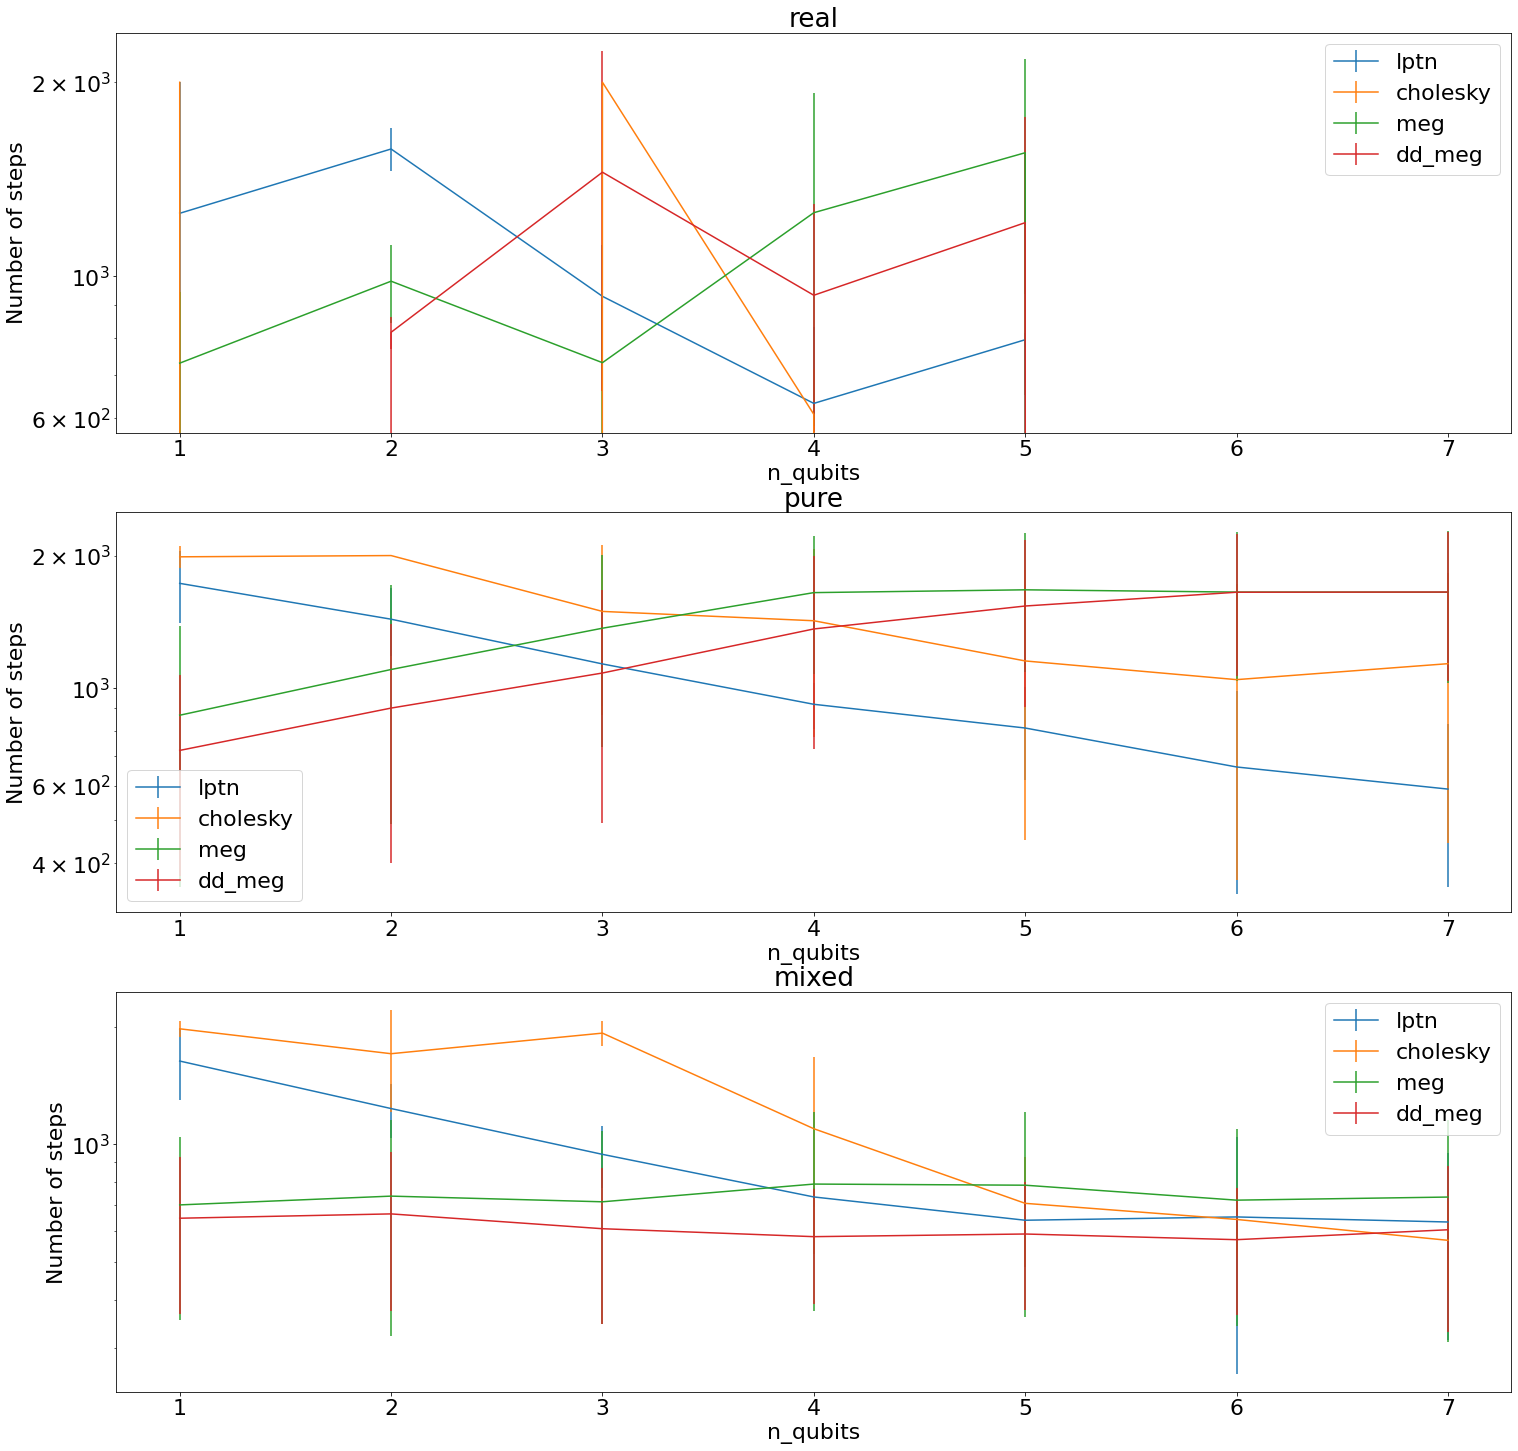

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            num_steps = np.array([[x['num_steps'] for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[tid]['tensor_rank'] for tid in task_ids])
                num_steps = num_steps[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(num_steps), np.std(num_steps)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("Number of steps")
#         plt.ylim((0,1))
        plt.yscale('log')
    plt.legend()

## Потребляемая память для разных алгоритмов и кубит

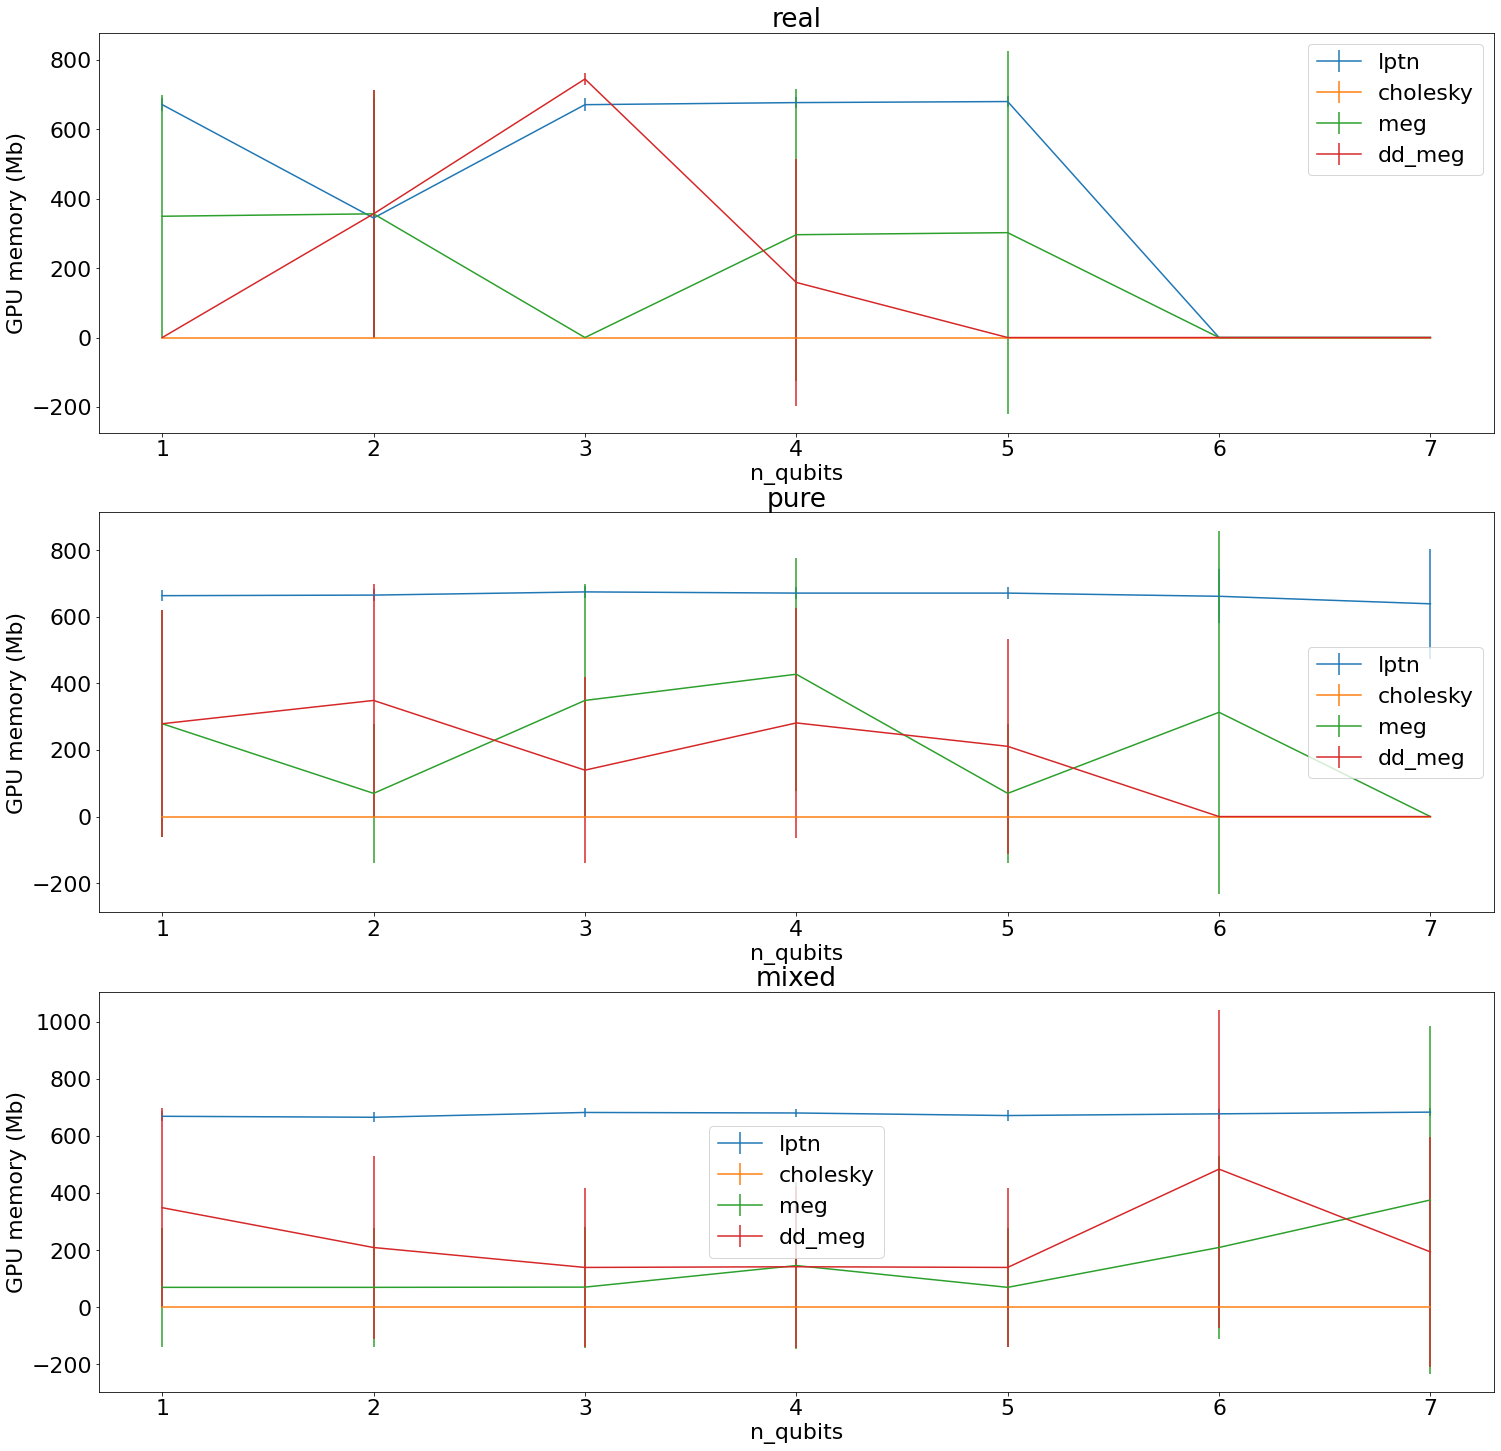

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            gpu_mem = np.array([[x.get('gpu_mem', 0) if not x.get('gpu_mem', 0) is None else 0 for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[tid]['tensor_rank'] for tid in task_ids])
                gpu_mem = gpu_mem[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(gpu_mem), np.std(gpu_mem)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("GPU memory (Mb)")
#         plt.ylim((0,1))
#         plt.yscale('log')
    plt.legend()

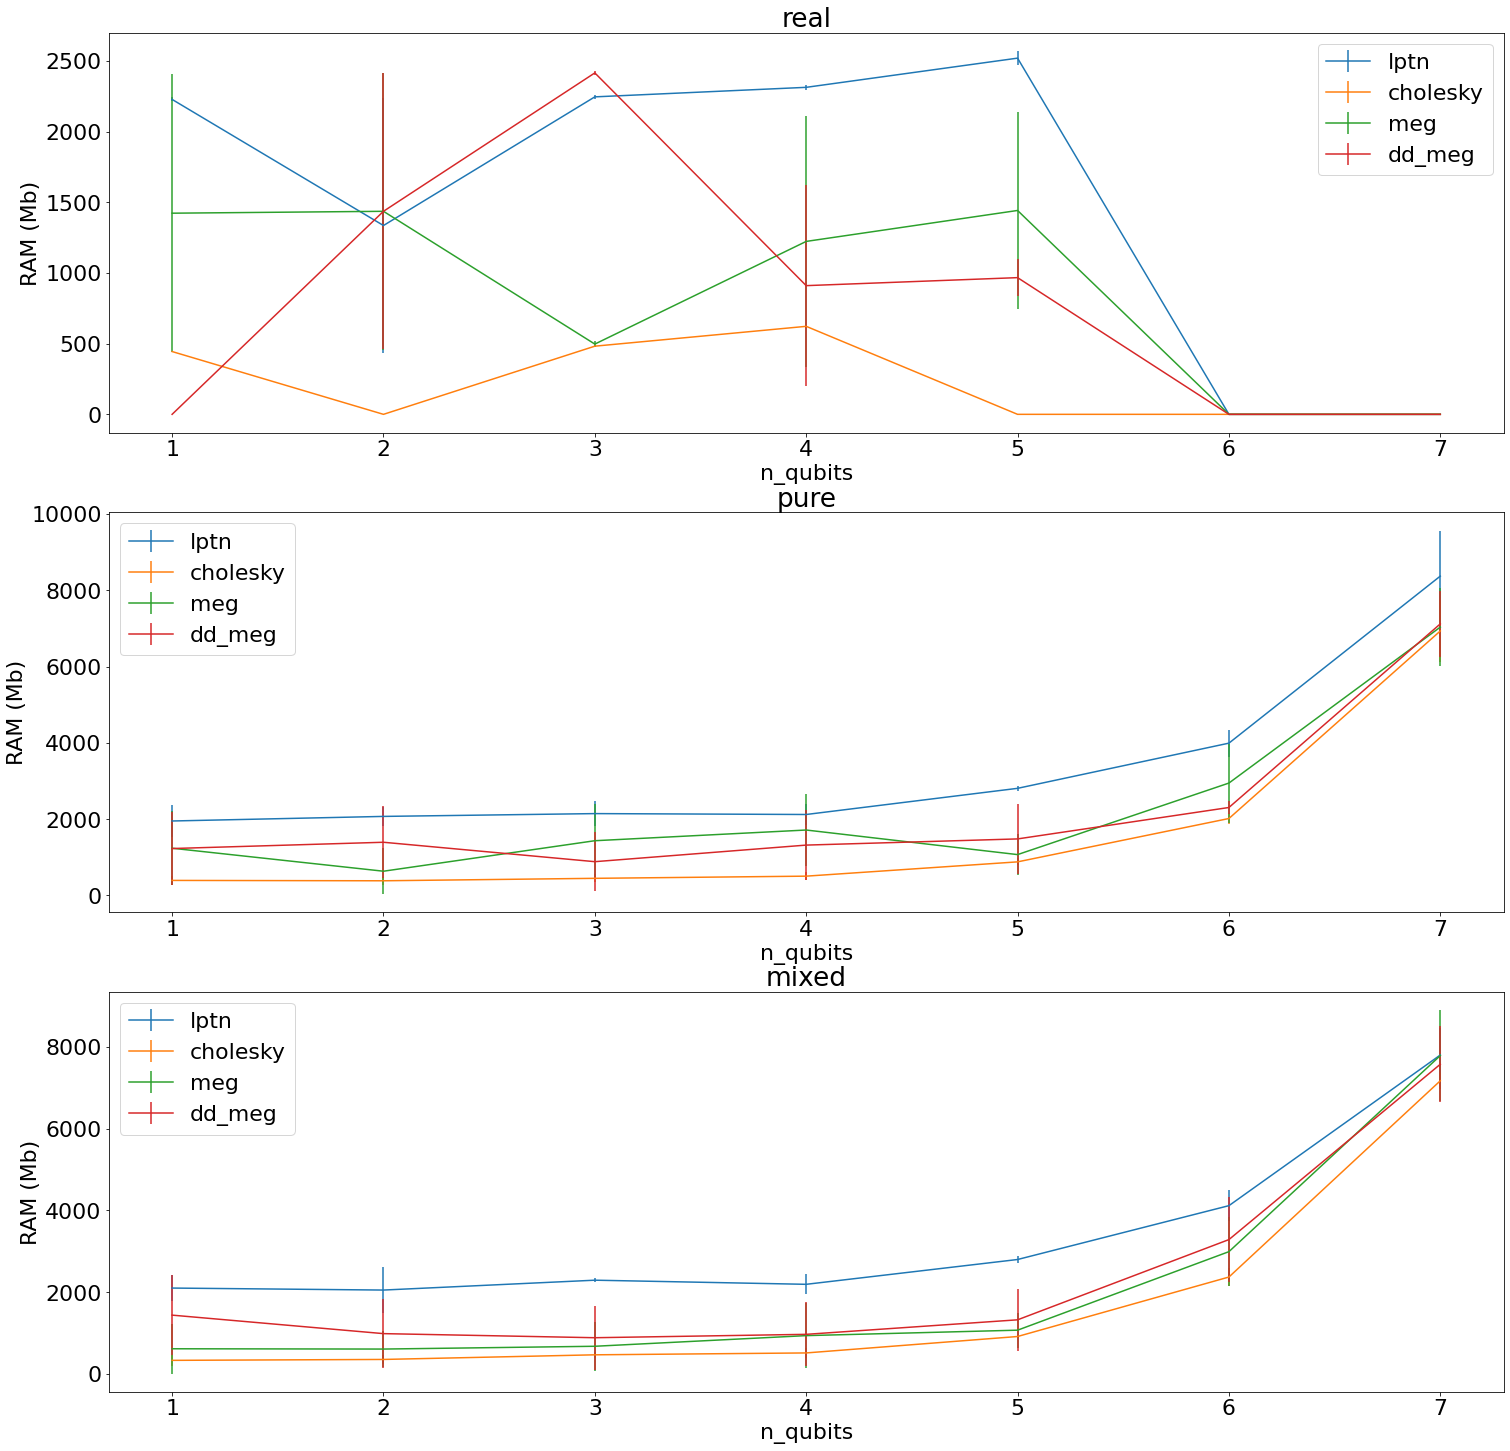

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            gpu_mem = np.array([[x.get('ram_mem', 0) if not x.get('ram_mem', 0) is None else 0 for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[tid]['tensor_rank'] for tid in task_ids])
                gpu_mem = gpu_mem[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(gpu_mem), np.std(gpu_mem)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("RAM (Mb)")
#         plt.ylim((0,1))
#         plt.yscale('log')
    plt.legend()

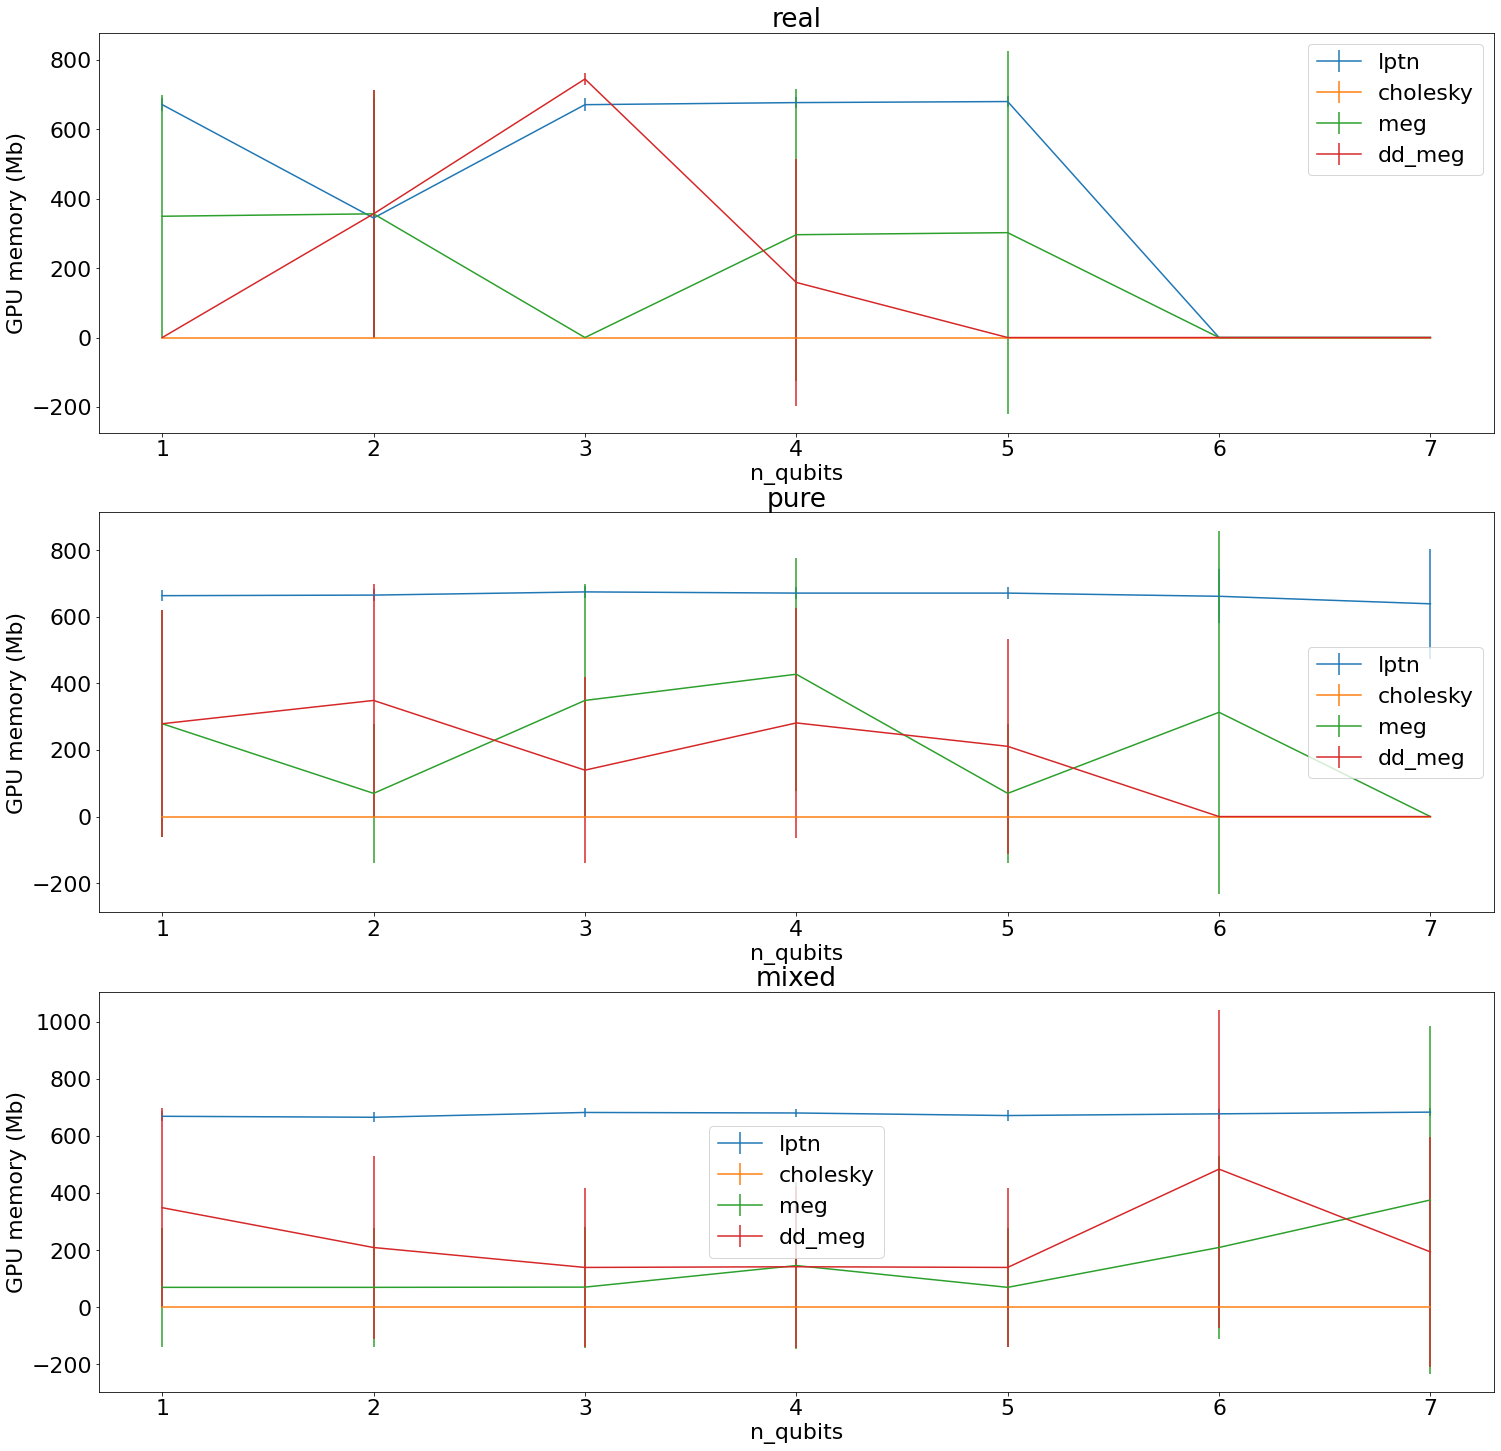

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            gpu_mem = np.array([[x.get('gpu_mem', 0) if not x.get('gpu_mem', 0) is None else 0 for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[tid]['tensor_rank'] for tid in task_ids])
                gpu_mem = gpu_mem[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(gpu_mem), np.std(gpu_mem)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("GPU memory (Mb)")
#         plt.ylim((0,1))
#         plt.yscale('log')
    plt.legend()

## Кросс-валидация на трейне и тесте

/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
<ipython-input-47-6b843cdedf9c>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Mean

/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

<ipython-input-47-6b843cdedf9c>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(rows_cnt, 1, i)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` 

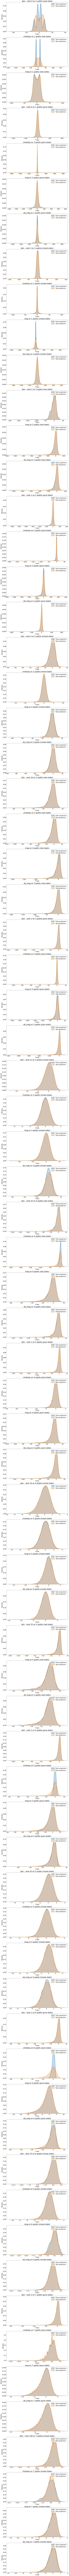

In [47]:
rows_cnt = len(qubits_range)*len(['real', 'pure', 'mixed'])*len(['lptn', 'cholesky', 'meg', 'dd_meg'])
plt.figure(figsize=(17,10*rows_cnt))
i = 1
for n_qubits in qubits_range:
    for data_type in ['real', 'pure', 'mixed']:
        for algorithm in ['lptn', 'cholesky', 'meg', 'dd_meg']:
            plt.subplot(rows_cnt, 1, i)
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            fidelities = []
            for tid in task_ids:
                res = read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))
                fidelities.append(max([v for r in res['results'] for v in r['fidelities']]))
            if not fidelities: continue
            best_task_id = task_ids[np.argmax(fidelities)]
            res = read_json(os.path.join(RESULTS_DIR, f'{best_task_id}.json'))
            algorithm_name = algorithm
            if algorithm == 'lptn':
                algorithm_name = f'{algorithm_name} - rank {tasks[best_task_id]["tensor_rank"]}'
            def tolist(vals):
                if isinstance(vals, list): return vals
                return [vals]
            ttest_train, ttest_test = [[v for r in res['results'] for v in tolist(r[test]) if not np.isinf(v)] for test in ['ttest_train', 'ttest_test']]
            sns.distplot(ttest_train, label='Train projectors', bins=1000, hist = False, kde = True,
                             kde_kws = {'shade': True, 'linewidth': 3})
            sns.distplot(ttest_test, label='Test projectors', bins=1000, hist = False, kde = True,
                             kde_kws = {'shade': True, 'linewidth': 3})

            plt.legend()
            plt.xlabel('T-test')
            plt.title(f'{algorithm_name} on {tasks[best_task_id]["n_qubits"]} qubits ({data_type} state)');
            i += 1

## График расстояния (Wasserstein) от числа кубит

In [64]:
from scipy.stats import wasserstein_distance as w_distance
from collections import defaultdict
data_types = ['real', 'pure', 'mixed']
distances = {k:defaultdict(list) for k in data_types}
for data_type in data_types:
    for algorithm in ['lptn', 'cholesky', 'meg', 'dd_meg']:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            fidelities = []
            for tid in task_ids:
                res = read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))
                fidelities.append(max([v for r in res['results'] for v in r['fidelities']]))
            if not fidelities: 
                distances[data_type][algorithm].append(np.nan)
                continue
            best_task_id = task_ids[np.argmax(fidelities)]
            res = read_json(os.path.join(RESULTS_DIR, f'{best_task_id}.json'))
            def tolist(vals):
                if isinstance(vals, list): return vals
                return [vals]
            ttest_train, ttest_test = [[v for r in res['results'] for v in tolist(r[test]) if not np.isinf(v)] for test in ['ttest_train', 'ttest_test']]
            distances[data_type][algorithm].append(w_distance(ttest_train, ttest_test))

In standard scale

In [74]:
np.arange(0,10)[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [95]:
def fill_nans(arr):
    arr = arr.copy()
    while True:
        nan_indices = np.argwhere(np.isnan(arr)).squeeze()
        for nan_idx in nan_indices:
            last_left_idx = -1
            for idx in np.arange(0, nan_idx)[::-1]:
                if not idx in nan_indices:
                    last_left_idx = idx
                    break
            last_right_idx = -1
            for idx in np.arange(nan_idx + 1, len(arr)):
                if not idx in nan_indices:
                    last_right_idx = idx
                    break
            if last_right_idx == -1 and last_left_idx != -1:
                arr[nan_idx] = arr[last_left_idx]
            elif last_left_idx == -1 and last_right_idx != -1:
                arr[nan_idx] = arr[last_right_idx]
            elif all([x == -1 for x in [last_left_idx, last_right_idx]]):
                return arr
            else:
                arr[nan_idx] = 0.5 * (arr[last_left_idx] + arr[last_right_idx])
        if len(nan_indices) == 0:
            break
    return arr

import pandas as pd
import numpy as np

def ewma(x, alpha=0.7):
    '''
    Returns the exponentially weighted moving average of x.

    Parameters:
    -----------
    x : array-like
    alpha : float {0 <= alpha <= 1}

    Returns:
    --------
    ewma: numpy array
          the exponentially weighted moving average
    '''
    # Coerce x to an array
    x = np.array(x)
    n = x.size

    # Create an initial weight matrix of (1-alpha), and a matrix of powers
    # to raise the weights by
    w0 = np.ones(shape=(n,n)) * (1-alpha)
    p = np.vstack([np.arange(i,i-n,-1) for i in range(n)])

    # Create the weight matrix
    w = np.tril(w0**p,0)

    # Calculate the ewma
    return np.dot(w, x[::np.newaxis]) / w.sum(axis=1)

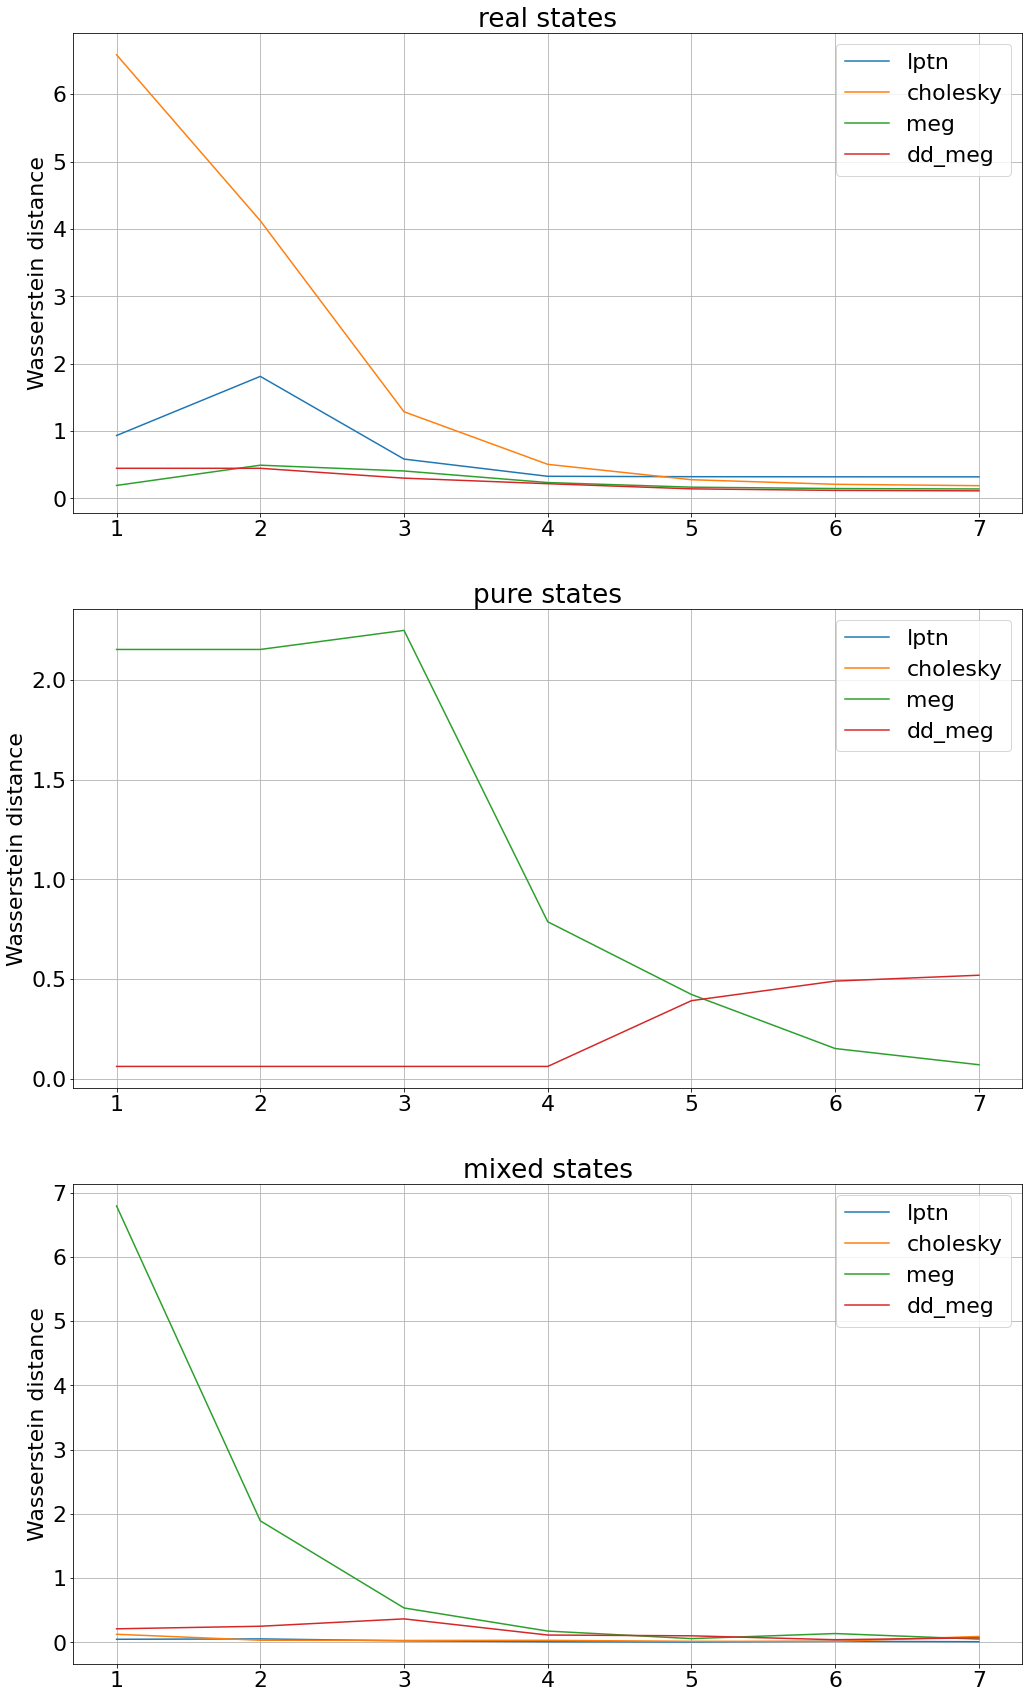

In [96]:
plt.rcParams.update({'font.size': 22})
rows_cnt = len(data_types)
plt.figure(figsize=(17,10*rows_cnt))
i = 1
for data_type in data_types:
    plt.subplot(rows_cnt, 1, i)
    for algorithm in ['lptn', 'cholesky', 'meg', 'dd_meg']:
        plt.plot(qubits_range, ewma(fill_nans(distances[data_type][algorithm])), label=algorithm)
    plt.title(f'{data_type} states')
    plt.ylabel('Wasserstein distance')
    plt.grid()
    plt.legend()
    i += 1

In log scale

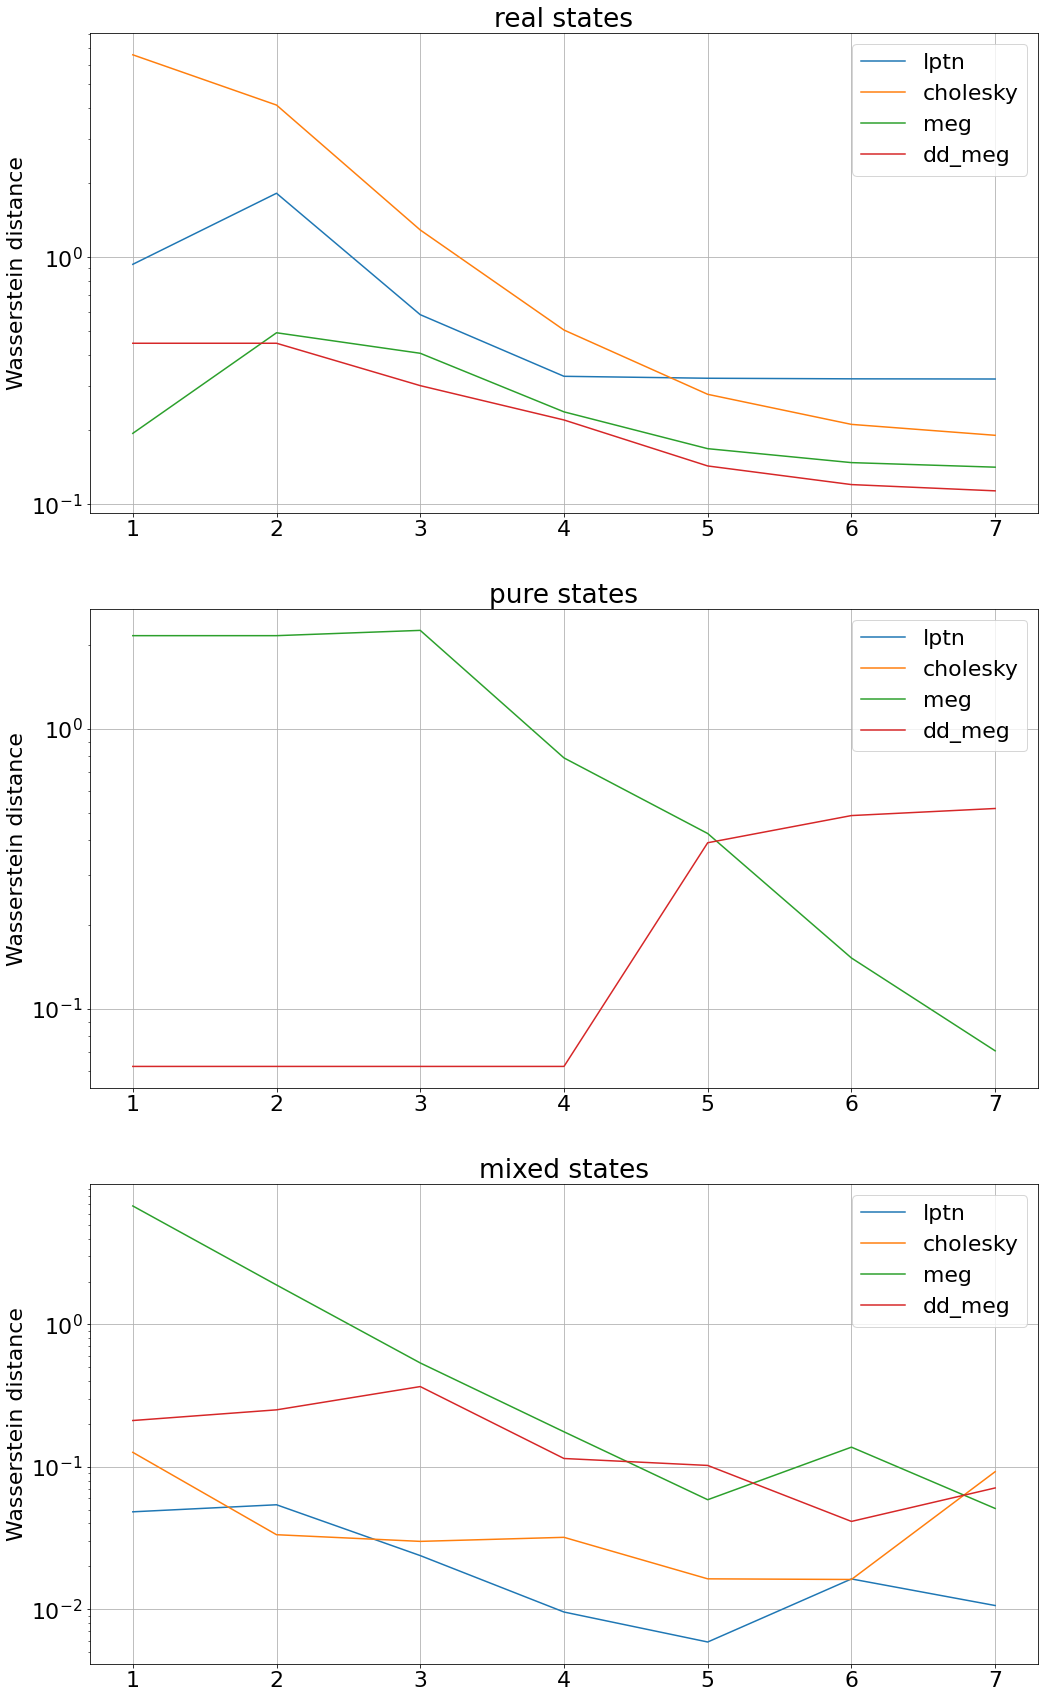

In [97]:
plt.rcParams.update({'font.size': 22})
rows_cnt = len(data_types)
plt.figure(figsize=(17,10*rows_cnt))
i = 1
for data_type in data_types:
    plt.subplot(rows_cnt, 1, i)
    for algorithm in ['lptn', 'cholesky', 'meg', 'dd_meg']:
        plt.plot(qubits_range, ewma(fill_nans(distances[data_type][algorithm])), label=algorithm)
    plt.title(f'{data_type} states')
    plt.ylabel('Wasserstein distance')
    plt.grid()
    plt.legend()
    plt.yscale('log')
    i += 1

## Зависимость от размера обуч выборки (числа проекторов)

In standard scale

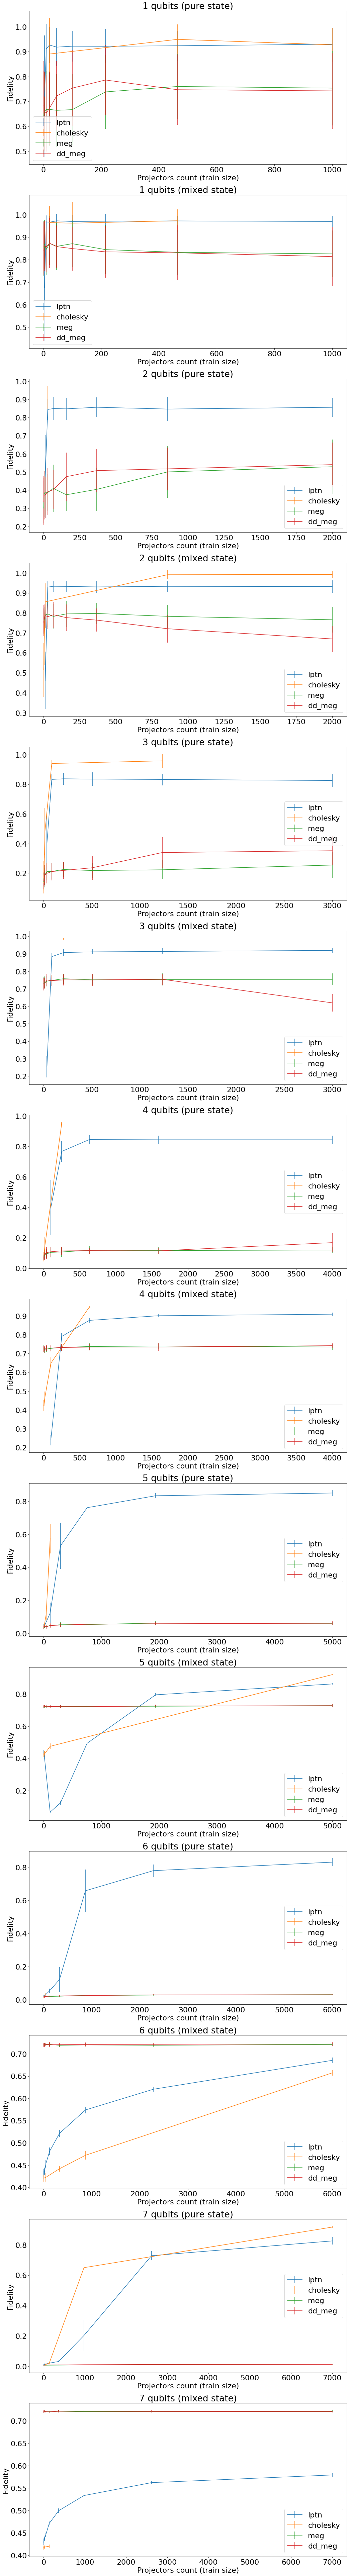

In [98]:
from collections import defaultdict
rows_cnt = len(qubits_range)*len(['pure', 'mixed'])
plt.figure(figsize=(17,10*rows_cnt))
i = 0
for n_qubits in qubits_range:
    for data_type in ['pure', 'mixed']:
        i += 1
        plt.subplot(rows_cnt, 1, i)
        plt.title(f'{n_qubits} qubits ({data_type} state)');
        for algorithm in ['lptn', 'cholesky', 'meg', 'dd_meg']:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            
#             fidelities = []
#             for tid in task_ids:
#                 res = read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))
#                 fidelities.append(max([v for r in res['results'] for v in r['fidelities']]))
#             if not fidelities: 
#                 distances[data_type][algorithm].append(np.nan)
#                 continue
#             best_task_id = task_ids[np.argmax(fidelities)]
            
            if algorithm == 'lptn':
                fidelities = defaultdict(lambda: defaultdict(list))
            else:
                fidelities = defaultdict(list)
            for tid in task_ids:
                res = read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))
                projectors_cnt = tasks[tid]['projectors_cnt']
                for r in res['results']:
                    if algorithm == 'lptn':
                        fidelities[projectors_cnt][tasks[tid]['tensor_rank']].append(max([v for v in r['fidelities']]))
                    else:
                        fidelities[projectors_cnt].append(max([v for v in r['fidelities']]))
            if not len(task_ids): continue
            projectors_cnt = list(sorted(fidelities.keys()))
            if algorithm == 'lptn':
                for proj_cnt in projectors_cnt:
                    best_rank, best_fid = -1, 0
                    for rank in fidelities[proj_cnt]:
                        fid = np.mean(fidelities[proj_cnt][rank])
                        if fid > best_fid:
                            best_fid = fid; best_rank = rank
                    fidelities[proj_cnt] = fidelities[proj_cnt][best_rank]
#             plt.plot(x, y, label=algorithm)

            _, caps, _ = plt.errorbar(projectors_cnt, 
                         [np.mean(fidelities[proj_cnt]) for proj_cnt in projectors_cnt], 
                         [np.std(fidelities[proj_cnt]) for proj_cnt in projectors_cnt], 
                         label=algorithm)
            for cap in caps:
                cap.set_markeredgewidth(1)

#             plt.yscale('log')
        plt.legend()
        plt.ylabel('Fidelity')
        plt.xlabel('Projectors count (train size)')

In log scale

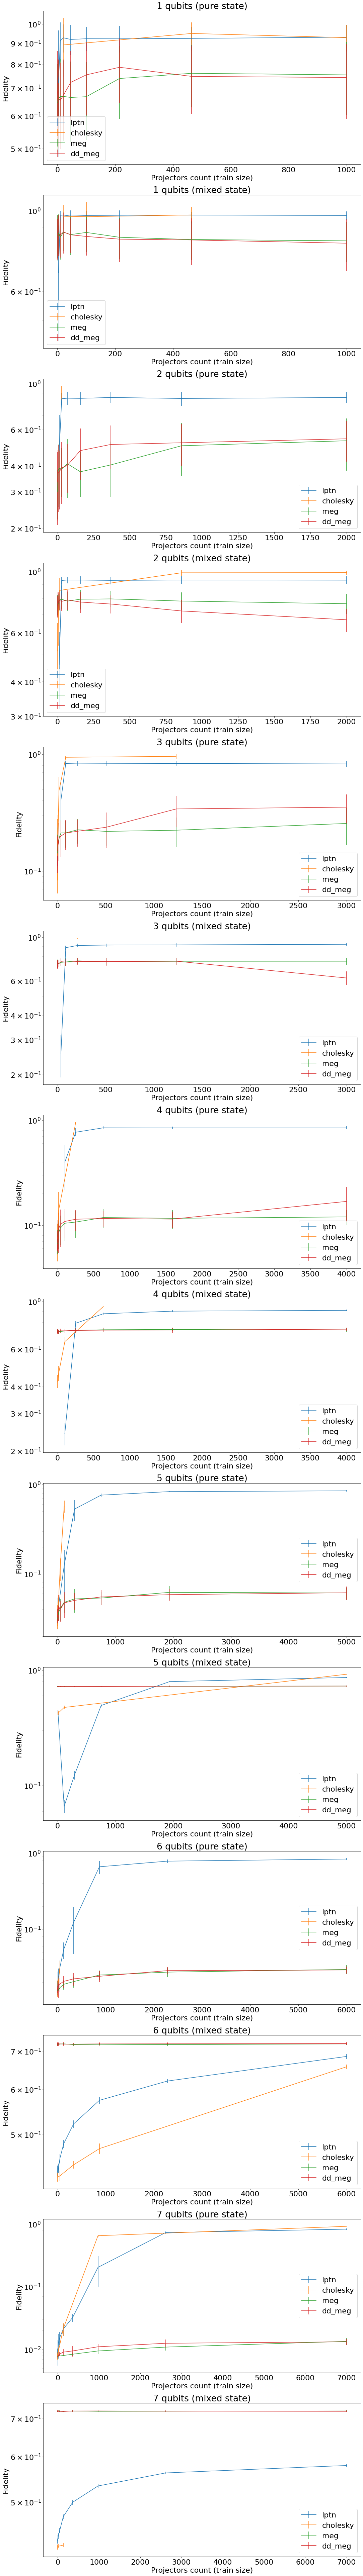

In [99]:
from collections import defaultdict
rows_cnt = len(qubits_range)*len(['pure', 'mixed'])
plt.figure(figsize=(17,10*rows_cnt))
i = 0
for n_qubits in qubits_range:
    for data_type in ['pure', 'mixed']:
        i += 1
        plt.subplot(rows_cnt, 1, i)
        plt.title(f'{n_qubits} qubits ({data_type} state)');
        for algorithm in ['lptn', 'cholesky', 'meg', 'dd_meg']:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            
#             fidelities = []
#             for tid in task_ids:
#                 res = read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))
#                 fidelities.append(max([v for r in res['results'] for v in r['fidelities']]))
#             if not fidelities: 
#                 distances[data_type][algorithm].append(np.nan)
#                 continue
#             best_task_id = task_ids[np.argmax(fidelities)]
            
            if algorithm == 'lptn':
                fidelities = defaultdict(lambda: defaultdict(list))
            else:
                fidelities = defaultdict(list)
            for tid in task_ids:
                res = read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))
                projectors_cnt = tasks[tid]['projectors_cnt']
                for r in res['results']:
                    if algorithm == 'lptn':
                        fidelities[projectors_cnt][tasks[tid]['tensor_rank']].append(max([v for v in r['fidelities']]))
                    else:
                        fidelities[projectors_cnt].append(max([v for v in r['fidelities']]))
            if not len(task_ids): continue
            projectors_cnt = list(sorted(fidelities.keys()))
            if algorithm == 'lptn':
                for proj_cnt in projectors_cnt:
                    best_rank, best_fid = -1, 0
                    for rank in fidelities[proj_cnt]:
                        fid = np.mean(fidelities[proj_cnt][rank])
                        if fid > best_fid:
                            best_fid = fid; best_rank = rank
                    fidelities[proj_cnt] = fidelities[proj_cnt][best_rank]
#             plt.plot(x, y, label=algorithm)

            _, caps, _ = plt.errorbar(projectors_cnt, 
                         [np.mean(fidelities[proj_cnt]) for proj_cnt in projectors_cnt], 
                         [np.std(fidelities[proj_cnt]) for proj_cnt in projectors_cnt], 
                         label=algorithm)
            for cap in caps:
                cap.set_markeredgewidth(1)

            plt.yscale('log')
        plt.legend()
        plt.ylabel('Fidelity')
        plt.xlabel('Projectors count (train size)')